# **Object Detection R-CNN**

**Region-Based approachs**

# **`Installation OpenCV pour: `**
+ lire des images
+ appliquer l'algo de recherche séléctive pour l'extraction des ROIs

In [ ]:
!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.8.0.76
Uninstalling opencv-contrib-python-4.8.0.76:
  Successfully uninstalled opencv-contrib-python-4.8.0.76
Found existing installation: opencv-python 4.8.0.76
Uninstalling opencv-python-4.8.0.76:
  Successfully uninstalled opencv-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 25.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

# **`Téléchargement et visualisation de la Base de données`**


In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tawfiqaadnane","key":"11006a77ccec9d5bc1471b07279cbe62"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sshikamaru/car-object-detection

 98% 110M/112M [00:01<00:00, 128MB/s] 
100% 112M/112M [00:01<00:00, 107MB/s]


In [ ]:
!unzip /content/car-object-detection.zip -d car-object-detection

Archive:  /content/car-object-detection.zip
replace car-object-detection/data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **`Visualisation du fichier CSV de la BD`**

In [ ]:
import os

print('Image(Train):',len(os.listdir('/content/car-object-detection/data/training_images')))
print('Image(Test):',len(os.listdir('/content/car-object-detection/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [ ]:
import pandas as pd


Data=pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')

In [ ]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
print('nombre de localisation dans Train data:',len(Data))

nombre de localisation dans Train data: 559


In [ ]:
Data.values.shape

(559, 5)

# **`Visualisation des exemples de la BD(image, boîte englobantes)`**

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


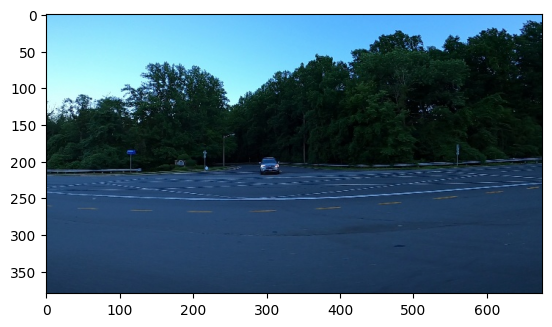

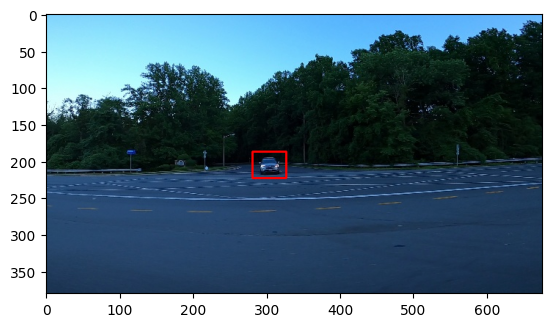

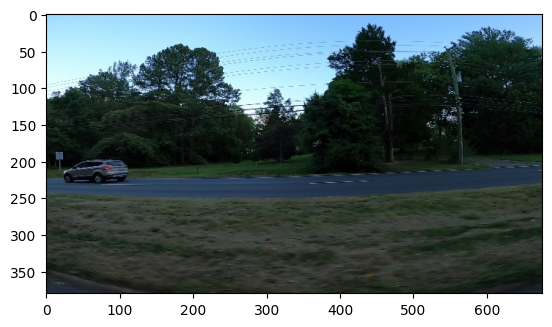

In [ ]:
import matplotlib.pyplot as plt
import cv2

for a,i in enumerate(Data.values):
  img=plt.imread('/content/car-object-detection/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

# **`Algorithme de la Recherche séléctive pour l'extraction des régions`**

In [ ]:
cv2.setUseOptimized(True) # Optimisation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Creation d'une instance de l'algo Selective search

In [ ]:
def selectiveSearch(image,ss):
  ss.setBaseImage(image) # chargement de l'image
  ss.switchToSelectiveSearchFast() # utilisation de la version fast de l'algo de la recherche sélective
  rects = ss.process()
  return rects



## - <font size="4" color="red"> Exemple d'application et de visualisation de l'algorithme de la recherche selective extraire des ROIs</font>

In [ ]:
def visualisationALLRoIs(image,ROI):
  for rect in ROI:
    x, y, w, h = rect
    imOut=cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  plt.figure()
  plt.imshow(imOut)

taille de l'image: (224, 224, 3)
nombre éventuel de boîtes englobantes: 213


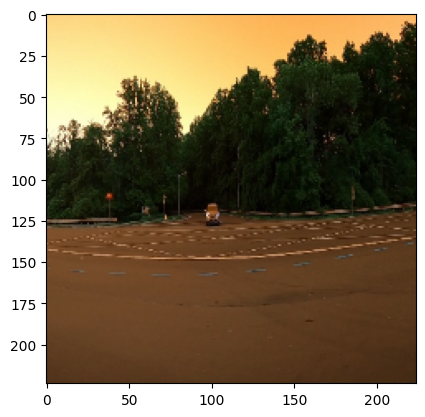

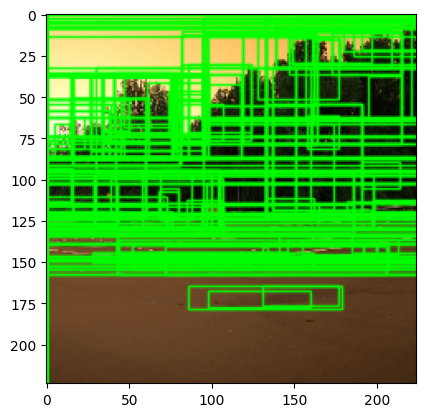

In [ ]:
im = cv2.imread('/content/car-object-detection/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
rects = selectiveSearch(im,ss) # Récupération des boites englobantes
print("taille de l'image:",im.shape)
print('nombre éventuel de boîtes englobantes:',len(rects))
visualisationALLRoIs(im,rects)

# **`Métrique IoU(Intersection over Union)`**

In [ ]:
#Iou and selective search
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# **`Extraction des RoIs à partir des images et labalisation des ROIs à base de l'utilisation de la métrique IoU avec un seuil de 0.5 `**

nombre de RoIs: 1101
46
nombre de RoIs: 1456
57


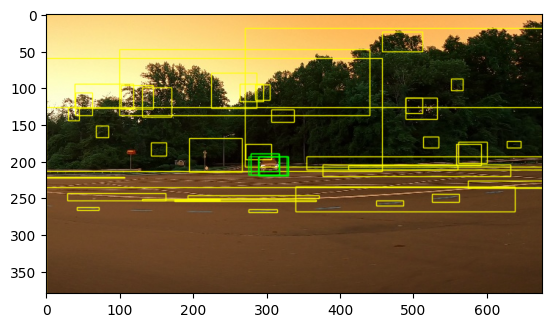

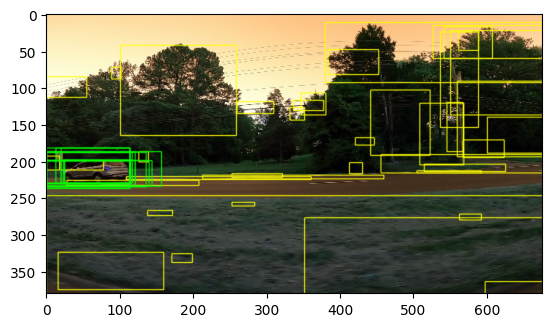

In [ ]:
def getBDImage(image,ROI,bbreel):
  image_liste=[]
  labels=[]
  ious=[]
  rois=[]
  rois_reel=[]
  nb_no_cars=0
  nb_cars=0
  print("nombre de RoIs:",len(ROI))
  for rect in ROI:
    x, y, w, h = rect
    bbRoi={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }

    imgExtraite=image[bbRoi['y1']:bbRoi['y2'],bbRoi['x1']:bbRoi['x2']] # crop l'image
    img_reshape=cv2.resize(imgExtraite,(128,128))/255.
    iou=get_iou(bbreel,bbRoi)

    if nb_cars<40:
         if iou>0.5:
              image_liste.append([img_reshape])
              labels.append(1)
              nb_cars=nb_cars+1
              ious.append(iou)
              rois.append(bbRoi)
              rois_reel.append(bbreel)

    if nb_no_cars<40:
        ious.append(iou)
        image_liste.append([img_reshape])
        if iou>0.5:
            labels.append(1)
            nb_cars=nb_cars+1
            rois.append(bbRoi)
            rois_reel.append(bbreel)


        else:

            labels.append(0)
            nb_no_cars=nb_no_cars+1

            rois.append(bbRoi)
            rois_reel.append(bbRoi)

  print(len(image_liste))
  return image_liste,labels,rois,rois_reel,ious





def visualisation(image,ROIs,bbreel):

  image_liste,labels,rois,rois_reel,iou=getBDImage(img,ROIs,bbreel)


  for i in range(len(labels)):
    bb=rois[i]
    if(labels[i]==1):


      cv2.rectangle(image, (bb["x1"], bb["y1"]), (bb["x2"], bb["y2"]), (0, 255, 0), 1, cv2.LINE_AA)
    else:
      cv2.rectangle(image, (bb["x1"], bb["y1"]), (bb["x2"], bb["y2"]), (255, 255, 0), 1, cv2.LINE_AA)

  plt.figure()
  plt.imshow(image)



for i,a in enumerate(Data.values):
  Name,xmin,ymin,xmax,ymax=a
  bbreel={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  img=cv2.imread('/content/car-object-detection/data/training_images/'+Name)

  ROIs = selectiveSearch(img,ss)

  #image_liste,labels,rois,iou=getBDImage(img,ROIs,bbreel)
  visualisation(img,ROIs,bbreel)
  if i==1:
    break

In [ ]:
def getBDAllImage(Data):
  imagesRoIs=[]
  labelsImages=[]
  CoordinatesRiOs=[]
  RiO_reel=[]
  for i,a in enumerate(Data.values):

    Name,xmin,ymin,xmax,ymax=a
    bbreel={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
    img=cv2.imread('/content/car-object-detection/data/training_images/'+Name)

    ROIs = selectiveSearch(img,ss)

    print("image:",i, " nb RoIs:",len(ROIs))

    image_liste,labels,rois,rois_reel,iou=getBDImage(img,ROIs,bbreel)
    imagesRoIs.extend(image_liste)
    labelsImages.extend(labels)
    CoordinatesRiOs.extend(rois)
    RiO_reel.extend(rois_reel)
    if i==200:
      break
    #visualisation(img,ROIs,bbreel)


  return imagesRoIs,labelsImages,RiO_reel,CoordinatesRiOs
#del imagesRoIs,labelsImages,RiO_reel,CoordinatesRiOs
imagesRoIs,labelsImages,RiO_reel,CoordinatesRiOs=getBDAllImage(Data)

image: 0  nb RoIs: 1101
nombre de RoIs: 1101
46
image: 1  nb RoIs: 1456
nombre de RoIs: 1456
57
image: 2  nb RoIs: 1403
nombre de RoIs: 1403
44
image: 3  nb RoIs: 1489
nombre de RoIs: 1489
44
image: 4  nb RoIs: 1315
nombre de RoIs: 1315
54
image: 5  nb RoIs: 1537
nombre de RoIs: 1537
41
image: 6  nb RoIs: 1430
nombre de RoIs: 1430
55
image: 7  nb RoIs: 1544
nombre de RoIs: 1544
43
image: 8  nb RoIs: 1117
nombre de RoIs: 1117
40
image: 9  nb RoIs: 1146
nombre de RoIs: 1146
44
image: 10  nb RoIs: 1663
nombre de RoIs: 1663
51
image: 11  nb RoIs: 1815
nombre de RoIs: 1815
45
image: 12  nb RoIs: 1725
nombre de RoIs: 1725
43
image: 13  nb RoIs: 1251
nombre de RoIs: 1251
42
image: 14  nb RoIs: 1894
nombre de RoIs: 1894
44
image: 15  nb RoIs: 1676
nombre de RoIs: 1676
46
image: 16  nb RoIs: 1754
nombre de RoIs: 1754
51
image: 17  nb RoIs: 1553
nombre de RoIs: 1553
51
image: 18  nb RoIs: 1779
nombre de RoIs: 1779
59
image: 19  nb RoIs: 1863
nombre de RoIs: 1863
53
image: 20  nb RoIs: 1846
nombr

#**`Répartition de la BD en deux sous-ensembles(train et validation)`**

In [ ]:
imagesRoIs=np.array(imagesRoIs).reshape(-1,128,128,3)
labelsImages=np.array(labelsImages)
#RiO_reel=np.array(RiO_reel)
#CoordinatesRiOs=np.array(CoordinatesRiOs)
#X=[]
#for i in range(len(imagesRoIs)):
  #X.append([imagesRoIs[i], RiO_reel[i],CoordinatesRiOs[i]])

In [ ]:
print("nombre d'image",len(imagesRoIs),"|nombre de labels:",len(labelsImages))
print("taille des images", imagesRoIs.shape)
print("taille des labels", labelsImages.shape)
#print("taille des rois", RiO_reel.shape,CoordinatesRiOs.shape)
#print(len(X))

nombre d'image 10157 |nombre de labels: 10157
taille des images (10157, 128, 128, 3)
taille des labels (10157,)


In [ ]:
print("nombre d'image qui ne contient aucune voiture:",len(labelsImages[labelsImages==0]),"|nombre d'image qui ne contient aucune voiture:",len(labelsImages[labelsImages==1]))

nombre d'image qui ne contient aucune voiture: 4040 |nombre d'image qui ne contient aucune voiture: 1006


Class: 0
la taille de l'image: (128, 128, 3)


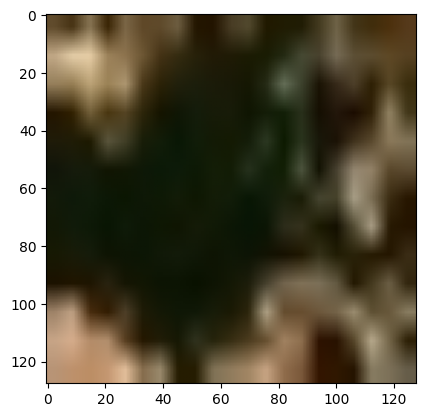

In [ ]:
i=random.randint(1,len(labelsImages))
print('Class:',labelsImages[i])
print("la taille de l'image:",imagesRoIs[i].shape)
plt.imshow(imagesRoIs[i])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(imagesRoIs,labelsImages,test_size=0.3, random_state=42)

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.7
index_train = np.random.choice(imagesRoIs.shape[0],int(imagesRoIs.shape[0]*train_rate),replace=False)
index_test  = list(set(range(imagesRoIs.shape[0])) - set(index_train))

#X, Y = shuffle(imagesRoIs,labelsImages)
#x_train, y_train = imagesRoIs[index_train],labelsImages[index_train]
#x_val, y_val = imagesRoIs[index_test],labelsImages[index_test]
#print(x_train.shape, y_train.shape)
#print(x_val.shape, y_val.shape)

In [ ]:
index_train

array([ 6602, 10020,  1836, ...,  7644,   722,   887])

In [ ]:
#del imagesRoIs,labelsImages#X

In [ ]:
def getImagesAndROI(X_v):
  images=[]
  RoIsReel=[]
  RoIsSS=[]
  for i in range(len(X_v)):
    images.append(X_v[i][0])
    RoIsReel.append(X_v[i][1])
    RoIsSS.append(X_v[i][2])
  return np.array(images),np.array(RoIsReel),np.array(RoIsSS)

In [ ]:
#x_train_images,x_train_rois,x_train_roisSS=getImagesAndROI(x_train)
#x_val_images,x_val_rois,x_val_roisSS=getImagesAndROI(x_val)

In [ ]:
#del x_train,x_val

In [ ]:
#x_train_images.shape

(3532, 224, 224, 3)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(np.array(y_train), num_classes=2)
y_val = to_categorical(np.array(y_val), num_classes=2)

In [ ]:
#print('x_train shape:',x_train_images.shape)

#print('x_val shape:',x_val_images.shape)
#print('y_train shape:',y_train.shape)
#print('y_val shape:',y_val.shape)

x_train shape: (3532, 224, 224, 3)
x_val shape: (1514, 224, 224, 3)
y_train shape: (3532, 2)
y_val shape: (1514, 2)


#**`Transfer learning:`**
+ Choix d'un modèle pré-entrainé
+ Apprentissage
+ Validation
+ Test

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from skimage import io
from skimage.transform import resize
import cv2
from skimage import segmentation
from skimage.future import graph
from skimage.measure import regionprops
from skimage import color

num_classes=2


# Charger le modèle VGG16 pré-entraîné (sans les couches fully connected)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Ajouter des couches fully connected
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Sortie pour la classification (nombre de classes)
output = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Geler les poids des couches convolutionnelles pré-entraînées
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## - <font size="4" color="red"> Apprentissage et validation</font>

In [ ]:
epoch=20
hist=model.fit(imagesRoIs[index_train],labelsImages[index_train],batch_size=30,epochs=epoch,validation_data=(imagesRoIs[index_test],labelsImages[index_test]))

Epoch 1/20
237/237 [==============================] - 21s 72ms/step - loss: 0.0980 - accuracy: 0.9668 - val_loss: 0.0426 - val_accuracy: 0.9846
Epoch 2/20
237/237 [==============================] - 13s 56ms/step - loss: 0.0494 - accuracy: 0.9838 - val_loss: 0.0387 - val_accuracy: 0.9882
Epoch 3/20
237/237 [==============================] - 13s 56ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0385 - val_accuracy: 0.9895
Epoch 4/20
237/237 [==============================] - 13s 57ms/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.0388 - val_accuracy: 0.9888
Epoch 5/20
237/237 [==============================] - 14s 57ms/step - loss: 0.0221 - accuracy: 0.9924 - val_loss: 0.0580 - val_accuracy: 0.9859
Epoch 6/20
237/237 [==============================] - 14s 58ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.0452 - val_accuracy: 0.9898
Epoch 7/20
237/237 [==============================] - 14s 58ms/step - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.0573 - val_accuracy:

## - <font size="4" color="red"> Test de classification des RoIs extraites à partir d'une image</font>

In [ ]:
def getBoundingBoxProposal(img_test, model, seuilConfiance=0.75):
  cars=[]
  rects = selectiveSearch(img_test,ss)
  print("nombre d'objets sur l'image: ",len(rects))
  for i in rects:
    x, y, w, h = i
    bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }

    img_data=img_test[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))/255.
    pred=model.predict(img_data.reshape(1,224,224,3), verbose=-1)

    if pred[0][1]>seuilConfiance:
        print("trouvé à la position: ",bb3, " avec un score:",pred[0][1] )
        cars.append([bb3,pred[0][1]])
    else:
        pass
    #except Exception as e:
    #  print('erreur',e)
  print("Combien y a-t-il de boîtes englobantes possibles pour l'estimation de classe de 1 :",len(cars))
  return cars

In [ ]:
photo_path='/content/car-object-detection/data/testing_images/vid_5_26720.jpg'#'/content/car-object-detection/data/testing_images/vid_5_27620.jpg'
img_test=cv2.imread(photo_path)

cars=getBoundingBoxProposal(img_test, model)


nombre d'objets sur l'image:  1505
trouvé à la position:  {'x1': 0, 'y1': 203, 'x2': 676, 'y2': 380}  avec un score: 0.82082045
trouvé à la position:  {'x1': 214, 'y1': 163, 'x2': 384, 'y2': 202}  avec un score: 0.99995875
trouvé à la position:  {'x1': 197, 'y1': 172, 'x2': 380, 'y2': 219}  avec un score: 0.9992945
trouvé à la position:  {'x1': 496, 'y1': 180, 'x2': 676, 'y2': 210}  avec un score: 0.9478771
trouvé à la position:  {'x1': 214, 'y1': 167, 'x2': 384, 'y2': 202}  avec un score: 0.99992144
trouvé à la position:  {'x1': 93, 'y1': 185, 'x2': 488, 'y2': 247}  avec un score: 0.99412304
trouvé à la position:  {'x1': 213, 'y1': 169, 'x2': 394, 'y2': 202}  avec un score: 0.9977914
trouvé à la position:  {'x1': 501, 'y1': 189, 'x2': 618, 'y2': 219}  avec un score: 0.9986572
trouvé à la position:  {'x1': 0, 'y1': 196, 'x2': 215, 'y2': 225}  avec un score: 0.9959085
trouvé à la position:  {'x1': 214, 'y1': 172, 'x2': 380, 'y2': 202}  avec un score: 0.8938757
trouvé à la position:  {'x

In [ ]:
print("indice du premier meilleur score:",np.argmax(np.array(cars)[:,1]), "score:",cars[np.argmax(np.array(cars)[:,1])][1])

indice du premier meilleur score: 79 score: 0.9999629


In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
def visualisationALLRoIsOfCar(image,ROICar):

  for rect in ROICar[:]:

    pt1=(rect[0]['x1'],rect[0]['y1'])
    pt2=(rect[0]['x2'],rect[0]['y2'])

    imOut=cv2.rectangle(image,pt1,pt2,(0 , 255 , 0),1)
    imOut = cv2.putText(imOut , "car:"+"{:.2f}".format(rect[1]*100) , (rect[0]['x1'] , rect[0]['y1'] - 10) , font , 0.5 , (255 , 0 , 0) , 1 , cv2.LINE_AA)

  plt.figure()
  plt.imshow(imOut);
  plt.title(f'Le numéro de classe est 1 et le score de la boîte englobante le plus élevée est : %{ROICar[np.argmax(np.array(ROICar)[:,1])][1]*100}')



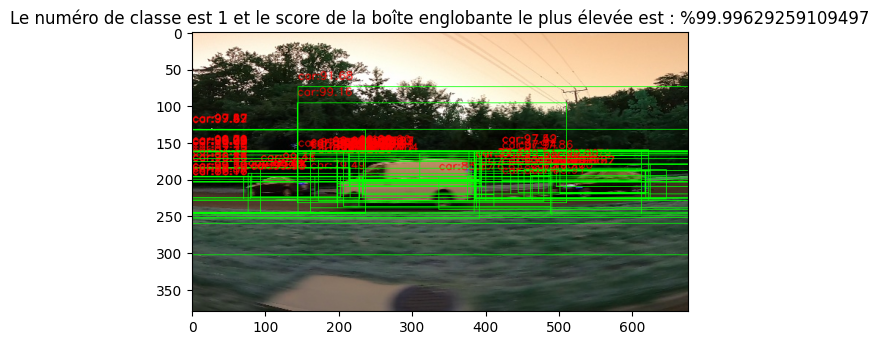

In [ ]:
img_test=cv2.imread(photo_path)

visualisationALLRoIsOfCar(img_test,cars)

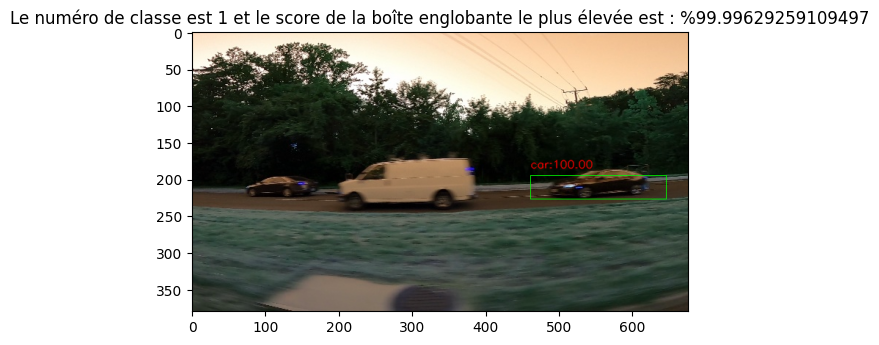

In [ ]:
img_test=cv2.imread(photo_path)

visualisationALLRoIsOfCar(img_test,[cars[np.argmax(np.array(cars)[:,1])]])

# **`Classification avec SVM`**

In [ ]:
from sklearn.svm import SVC
from tensorflow.keras.models import Model

# Entraîner un classificateur SVM sur les caractéristiques extraites
vgg_features = Model(inputs=model.input, outputs=model.layers[-4].output)  # Avant la première couche dense
train_features = vgg_features.predict(x_train_images)
val_features = vgg_features.predict(x_val_images)
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)
svm_classifier.fit(train_features, np.argmax(y_train, axis=1))

96/96 [==============================] - 13s 132ms/step


SVC(kernel='linear', probability=True)

### exemple de raffinement des ROI

In [ ]:
from sklearn.linear_model import LinearRegression
def affinement_ClassificationBoxProposes(cars,seuil_confiance=0.7):

# Affiner les propositions de régions avec SVM

  refined_boxes = []

  for rect in cars:

    x1,y1=(rect[0]['x1'],rect[0]['y1'])
    x2,y2=(rect[0]['x2'],rect[0]['y2'])
    roi = img_test[y1:y2, x1:x2]

    # Prétraiter l'image de la proposition pour l'adapter au modèle VGG16
    roi = cv2.resize(roi, (224, 224))/255.
    roi = np.expand_dims(roi, axis=0)


    # Extraire les caractéristiques avec VGG16
    features = vgg_features.predict(roi)

    # Prédire la classe avec le classificateur SVM
    predicted_class = svm_classifier.predict_proba(features)

    #print(np.argmax(predicted_class),(predicted_class),predicted_class[0][1])

    # Ajouter la boîte avec la probabilité de la classe comme score
    if predicted_class[0][1]>seuil_confiance:
      refined_boxes.append([rect[0] , predicted_class[0][1]])
  return refined_boxes


refined_boxes=affinement_ClassificationBoxProposes(cars,seuil_confiance=0.75)

print(len(cars), len(refined_boxes))


1/1 [==============================] - 0s 34ms/step
105 39


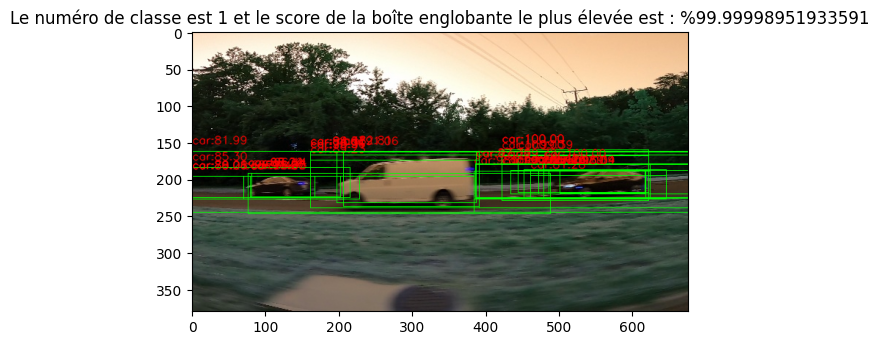

In [ ]:
img_test=cv2.imread(photo_path)

visualisationALLRoIsOfCar(img_test,refined_boxes)

# **`non_max_suppression`**

In [ ]:
# Fonction pour appliquer la suppression non maximale (NMS)
def non_max_suppression(boxes, threshold):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)

    # Trier les boîtes par score de confiance (probabilité dans le cas de détection d'objets)
    scores = boxes[:, -1]
    sorted_indices = np.argsort(scores)
    print(sorted_indices)

    selected_boxes = []

    while len(sorted_indices) > 0:
        # Sélectionner la boîte avec le score le plus élevé
        last_index = len(sorted_indices) - 1
        selected_index = sorted_indices[last_index]
        print(scores[last_index])
        selected_box = boxes[selected_index,0]
        selected_boxes.append(boxes[selected_index].tolist())

        # Calculer IoU avec les autres boîtes
        #print(selected_box)
        #print(box)
        ious = [get_iou(selected_box, box) for box in boxes[sorted_indices[:-1],0]]

        # Filtrer les boîtes qui ont un IoU élevé avec la boîte sélectionnée
        high_iou_indices = np.where(np.array(ious) > threshold)[0]
        sorted_indices = np.delete(sorted_indices, np.concatenate(([last_index], high_iou_indices)))

    return selected_boxes

In [ ]:
# Appliquer la suppression non maximale (NMS)
nms_threshold = 0.3  # Ajustez cela en fonction de vos besoins
final_boxes = non_max_suppression(refined_boxes, nms_threshold)

print(len(refined_boxes),len(final_boxes))

[ 5 12 24  9 27 28 38 30  2 16  6 25 18  1 14 32 37 29  3 26  8  0 17 19
 20 11 31 36 10 22  4 33 35  7 15 23 21 13 34]
0.8199285653976335
0.8832044739716677
0.937132742497829
39 3


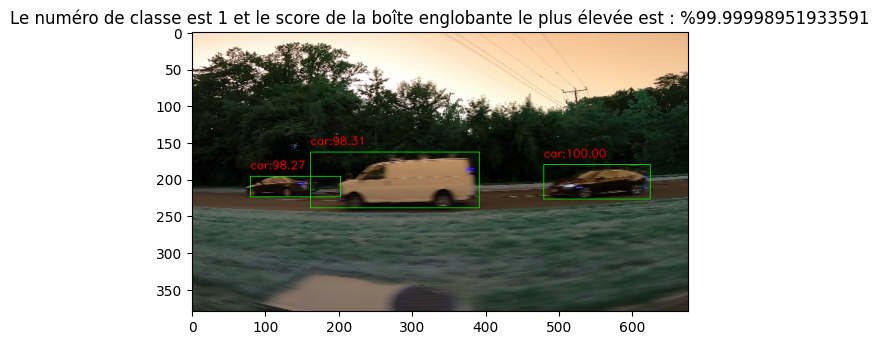

In [ ]:
img_test=cv2.imread(photo_path)

visualisationALLRoIsOfCar(img_test,final_boxes)

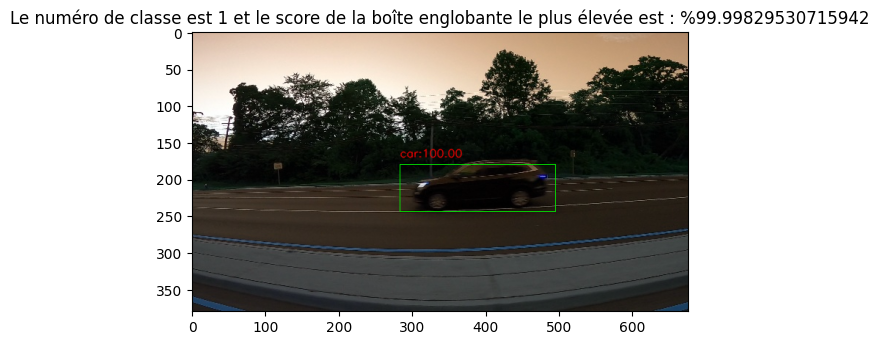

In [ ]:
img_test=cv2.imread(photo_path)

visualisationALLRoIsOfCar(img_test,[final_boxes[np.argmax(np.array(final_boxes)[:,1])]])